# Travel Insurance Claim Detection
### Created By : Stefanus William Alexander

## Business Problem Understanding

**Context**  

Perusahaan travel asuransi memiliki fokus utama untuk melindungi pelanggan dari risiko selama perjalanan, seperti pembatalan perjalanan, kehilangan bagasi, keterlambatan penerbangan, atau kebutuhan medis darurat. Namun, tidak semua pelanggan mengajukan klaim meskipun memiliki polis asuransi, sehingga terdapat pola klaim yang dapat dianalisis. Data pemegang polis di perusahaan asuransi merupakan data historis, terdiri dari destinasi, produk asuransi, dan sebagainya.

**Problem Statement :**

Perusahaan ingin meningkatkan efisiensi operasional dan profitabilitas dengan memprediksi apakah seorang pelanggan kemungkinan besar akan mengajukan klaim asuransi perjalanan atau tidak. Hal ini bertujuan untuk:

1. Manajemen Risiko: Mengidentifikasi pelanggan dengan risiko klaim tinggi sehingga dapat disesuaikan premi atau kebijakan layanan.
2. Optimalisasi Proses Klaim: Memprioritaskan klaim pelanggan yang benar-benar valid untuk mempercepat pemrosesan.

**Goals :**

Maka berdasarkan permasalahan tersebut, perusahaan ingin memprediksi apakah seorang pelanggan akan mengajukan klaim atau tidak (Claim: Yes/No) berdasarkan data pelanggan, perjalanan, dan produk asuransi. Sehingga dapat memenuhi 3 tujuan yaitu:
1. Prediksi yang Akurat: Menggunakan data pelanggan dan perjalanan untuk memprediksi klaim secara akurat.
2. Mengurangi Kerugian Finansial: Mengelola biaya klaim dengan lebih baik melalui prediksi resiko klaim.
3. Peningkatan Pelayanan: Memberikan pengalaman pelanggan yang lebih baik dengan mempercepat penanganan klaim.


**Analytic Approach :**

Memprediksi apakah pelanggan akan mengajukan klaim asuransi perjalanan atau tidak (Claim: Yes/No) menggunakan data pelanggan, perjalanan, dan informasi produk dari data historikal pelanggan sebelumnya. Fokus utamanya adalah mengurangi false negatives (klaim valid yang tidak terdeteksi) dan meningkatkan recall.


**Metric Evaluation**

<img src='Metric.PNG'>


Type 1 error : False Positive  
- Model memprediksi bahwa customer akan melakukan klaim (berisiko), tetapi kenyataannya customer tersebut tidak melakukan klaim.
- Dampak : 
    - Overpricing Premi (Premi Terlalu Tinggi):
        - Karena model memprediksi customer sebagai berisiko tinggi, perusahaan mungkin menaikkan premi untuk mencerminkan risiko tersebut.
        - Jika premi terlalu mahal, customer yang sudah ada mungkin merasa tidak puas dan berhenti memperpanjang polis (churn), sehingga perusahaan kehilangan pendapatan dari premi mereka.
    - Hilangnya Pelanggan Loyal:
        - Customer yang merasa diperlakukan tidak adil karena premi yang terlalu mahal mungkin mencari alternatif lain (kompetitor).
        - Kehilangan pelanggan loyal dapat mengurangi pendapatan jangka panjang. 
    - Inefisiensi Alokasi Sumber Daya:
        - Perusahaan mungkin mengalokasikan sumber daya tambahan (misalnya, analisis risiko lebih dalam atau layanan pelanggan khusus) untuk pelanggan yang sebenarnya tidak membutuhkan perhatian ekstra.
        - Biaya operasional meningkat tanpa memberikan manfaat nyata.

Type 2 error : False Negative  
- Model memprediksi bahwa customer tidak akan melakukan klaim (tidak berisiko), tetapi kenyataannya customer tersebut melakukan klaim.
- Dampak : 
    - Klaim Tak Terduga:
        - Karena model salah memperkirakan bahwa customer tidak berisiko, perusahaan tidak memprioritaskan pelanggan ini untuk tindakan mitigasi risiko (misalnya, edukasi pelanggan, pengawasan ekstra, atau penyesuaian premi).
        - Ketika klaim terjadi, perusahaan harus membayar nilai klaim secara penuh, yang bisa sangat besar jika klaimnya signifikan (misalnya, kecelakaan besar atau kehilangan barang mahal).
    - Premi yang Tidak Sesuai (Underpricing):
        - Jika pelanggan ini sebenarnya berisiko tinggi tetapi diprediksi tidak berisiko, premi yang ditetapkan mungkin terlalu rendah untuk menutupi potensi klaim.
        - Kerugian: Premi yang diterima tidak cukup untuk menutupi biaya klaim.
    - Kerugian pada Profitabilitas:
        - Setiap klaim yang tidak diprediksi akan mengurangi margin keuntungan perusahaan, terutama jika pelanggan tersebut adalah bagian dari segmen yang dianggap "aman" dan tidak dialokasikan premi risiko.

## Library

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
import shap 

# Model Selection
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier, RUSBoostClassifier, BalancedRandomForestClassifier
from sklearn.metrics import recall_score,ConfusionMatrixDisplay

# Imbalance Dataset
from imblearn.pipeline import Pipeline

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

## Data Understanding

Dataset source : [Data Travel Insurance](https://drive.google.com/drive/u/0/folders/1sRZ5xnpsiMID6RFAVPkQN4RLyivdnLAG)

### Attribute Information

| Attribute | Description |
| --- | --- |
| Agency | Nama agensi. |
| Agency Type | Jenis agensi asuransi perjalanan. |
| Distribution Channel | Saluran distribusi agensi asuransi perjalanan. |
| Product Name | Nama produk asuransi perjalanan. |
| Gender | Jenis kelamin tertanggung. |
| Duration | Durasi perjalanan. |
| Destination | Destinasi perjalanan. |
| Net Sales | Jumlah penjualan polis asuransi perjalanan. |
| Commission (in value) | Komisi yang diterima oleh agensi asuransi perjalanan. |
| Age | Usia tertanggung. |
| Claim (Target) | Status klaim. |

In [2]:
#Load Dataset
df = pd.read_csv('data_travel_insurance.csv')
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


Data terdiri dari 44328 baris dan 11 kolom

In [3]:
data=[]
for i in df.columns:
    data.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum())/len(df))*100),2),
        df[i].nunique(),
        df[i].drop_duplicates().values
    ])

pd.DataFrame(data, columns=[
    'kolom',
    'tipe',
    'null',
    'persentase null',
    'unique',
    'unique Data'
])

,kolom,tipe,null,persentase null,unique,unique Data
0,Agency,object,0,0.00,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, ..."
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Annual Silver Plan, Cancellation Plan, Basic ..."
4,Gender,object,31647,71.39,2,"[F, nan, M]"
5,Duration,int64,0,0.00,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 37..."
6,Destination,object,0,0.00,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KO..."
7,Net Sales,float64,0,0.00,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 8..."
8,Commision (in value),float64,0,0.00,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88,..."
9,Age,int64,0,0.00,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 5..."


Kolom `Gender` yang memiliki data NaN sebanyak 31647 (71.39%), sehingga kolom `Gender` ini akan didrop.

In [4]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [5]:
print(f"Jumlah data duplikat : {df.duplicated().sum()} ({round(df.duplicated().sum()/len(df)*100,2)}%)")

Jumlah data duplikat : 4667 (10.53%)


Kolom Target Claim:

- No : 0
- Yes : 1

Kolom Kategorikal:

- Agency
- Agency Type
- Distribution Channel
- Product Name
- Gender
- Destination

Kolom Numerikal:

- Duration
- Net Sales
- Commision (in Value)
- Age

## Data Cleaning

Ada data yang hilang/kosong di fitur/kolom Gender sebesar 71%, lalu terdapat juga data duplikat sebesar 11.2%, kemudian maka kita akan memperbaiki semua datanya dan membuatnya menjadi siap pakai untuk melakukan analisa terhadap masalahnya dan juga pembuatan model machine learningnya.

In [6]:
data=[]
for i in df.columns:
    data.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum())/len(df))*100),2),
        df[i].nunique(),
        df[i].drop_duplicates().values
    ])

pd.DataFrame(data, columns=[
    'kolom',
    'tipe',
    'null',
    'persentase null',
    'unique',
    'unique Data'
])

,kolom,tipe,null,persentase null,unique,unique Data
0,Agency,object,0,0.00,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, ..."
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Annual Silver Plan, Cancellation Plan, Basic ..."
4,Gender,object,31647,71.39,2,"[F, nan, M]"
5,Duration,int64,0,0.00,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 37..."
6,Destination,object,0,0.00,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KO..."
7,Net Sales,float64,0,0.00,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 8..."
8,Commision (in value),float64,0,0.00,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88,..."
9,Age,int64,0,0.00,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 5..."


### 1. Data Missing

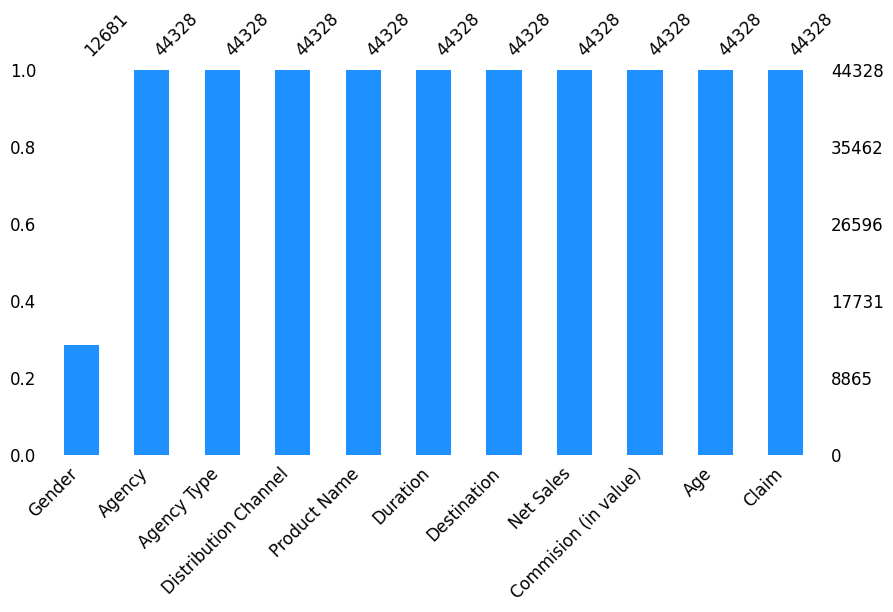

In [7]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

Terlihat dari Bar Plot diatas, bahwa kolom `Gender` memiliki missing values/data yang hilang sangat banyak. (informasi ini sebenarnya dapat dilihat juga ditable atas sebesar 71.39% data hilang)

<Axes: >

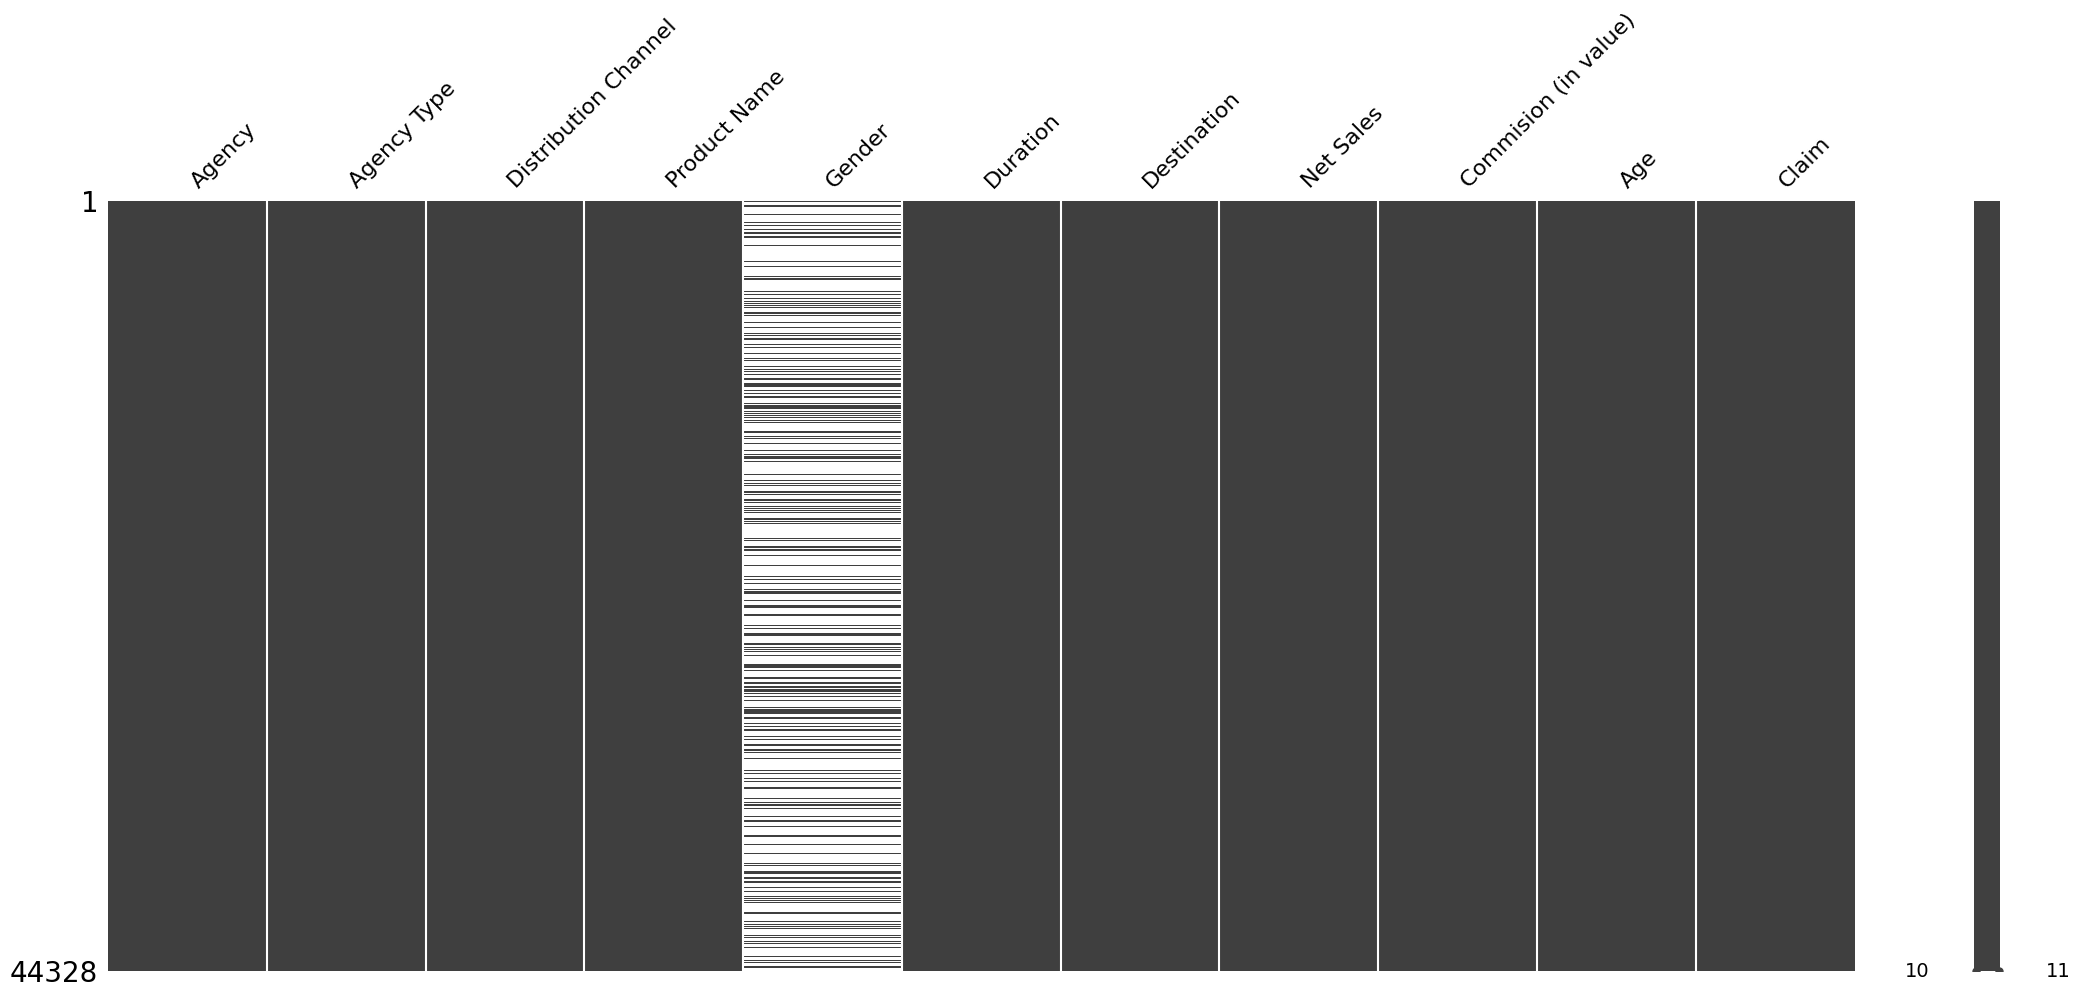

In [8]:
missingno.matrix(df)

Terlihat bahwa missing value/data yang hilang pada kolom `Gender` memiliki pola yang cukup acak.

In [9]:
df.drop(['Gender'],axis=1, inplace=True)

Dikarenakan kolom `Gender` memiliki data NaN sebanyak 31647 (71.39%), sehingga kolom `Gender` ini akan didrop.

### 2. Data Duplikat

In [10]:
print(f"Jumlah data duplikat : {df.duplicated().sum()} ({round(df.duplicated().sum()/len(df)*100,2)}%)")

Jumlah data duplikat : 5004 (11.29%)


In [11]:
df.drop_duplicates(inplace=True)

Dikarenakan data memiliki duplikat sebanyak 5004 (11.29%) data, sehingga duplikat akan dihapus agar tidak terjadi kebiasan data saat melakukan pembelajaran model.

### 3. Merubah Data Claim Menjadi Numerik

In [12]:
df['Claim'] = df['Claim'].map({
    'No' : 0,
    'Yes' : 1
})

In [13]:
df['Claim'].value_counts()

Claim
0    38651
1      673
Name: count, dtype: int64

In [14]:
df["Claim"].value_counts(normalize=True)

Claim
0    0.982886
1    0.017114
Name: proportion, dtype: float64

Distribusi target tidak seimbang (*imbalance*) dengan kelas 0 sebanyak 38651 dan kelas 1 sebanyak 673 (98 : 2). Hal ini menandakan data customer yang mengajukan Claim jauh lebih sedikit dibanding data customer Non Claim

### Distribusi Kategorikal Features

Kolom Kategorikal:

- Agency
- Agency Type
- Distribution Channel
- Product Name
- Destination

Dikarenakan data yang sangat tidak seimbang dari target klaim dan tidak klaim yaitu ratio 98 : 2 maka disini distribusi kategorikal fitur lebih berfokus kepada `Claim` kelas 1


#### 1. Feature `Agency`

In [15]:
(pd.crosstab(df['Agency'], df['Claim'], normalize="all")*100).round(3).sort_values(1,ascending=False)

Claim,0,1
Agency,,
C2B,12.539,1.025
EPX,53.039,0.338
CWT,14.398,0.163
LWC,1.076,0.074
JZI,10.708,0.056
KML,0.570,0.013
SSI,1.795,0.013
JWT,0.712,0.010
CCR,0.285,0.005


`Agency`: 'C2B', 'EPX', 'CWT', 'LWC' mempengaruhi `Claim` kelas 1 lumayan signifikan dibanding `Agency` lainnya.

<Axes: xlabel='Agency', ylabel='count'>

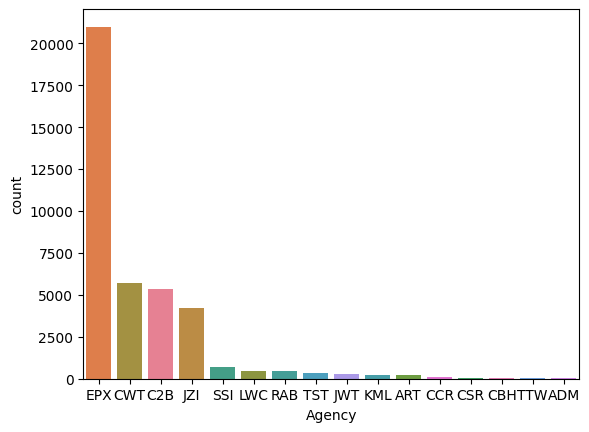

In [16]:
sns.countplot(data=df, x="Agency", hue="Agency", order=df['Agency'].value_counts().index)

In [17]:
df_Agency = pd.DataFrame({"Agency" : df["Agency"].value_counts().index,
                          "Jumlah" : df["Agency"].value_counts().values,
                          "Persentase" : (df["Agency"].value_counts(normalize=True)*100).round(2).values})
df_Agency

,Agency,Jumlah,Persentase
0,EPX,20990,53.38
1,CWT,5726,14.56
2,C2B,5334,13.56
3,JZI,4233,10.76
4,SSI,711,1.81
5,LWC,452,1.15
6,RAB,440,1.12
7,TST,329,0.84
8,JWT,284,0.72
9,KML,229,0.58


In [18]:
def mapping_agency(x):
    if x in ['C2B', 'EPX', 'CWT', 'LWC']:
        return x
    else:
        return 'Others'
df['Agency'] = df['Agency'].apply(mapping_agency)
df['Agency'].unique()

array(['C2B', 'EPX', 'Others', 'CWT', 'LWC'], dtype=object)

Pada kolom `Agency` data selain 'C2B', 'EPX', 'CWT', 'LWC' akan diubah menjadi 'Others'

<Axes: xlabel='Agency', ylabel='count'>

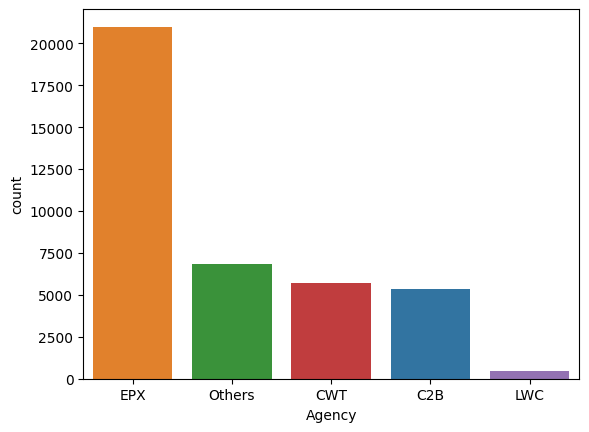

In [19]:
sns.countplot(data=df, x="Agency", hue="Agency", order=df['Agency'].value_counts().index)

In [20]:
df_Agency = pd.DataFrame({"Agency" : df["Agency"].value_counts().index,
                          "Jumlah" : df["Agency"].value_counts().values,
                          "Persentase" : (df["Agency"].value_counts(normalize=True)*100).round(2).values})
df_Agency

,Agency,Jumlah,Persentase
0,EPX,20990,53.38
1,Others,6822,17.35
2,CWT,5726,14.56
3,C2B,5334,13.56
4,LWC,452,1.15


`Agency` terbanyak berada pada data 'EPX' dengan jumlah 20990 (53.38%)

#### 2. Feature `Agency Type`

In [21]:
(pd.crosstab(df['Agency Type'], df['Claim'], normalize="all")*100).round(3).sort_values(1,ascending=False)

Claim,0,1
Agency Type,,
Airlines,27.446,1.106
Travel Agency,70.842,0.605


<Axes: xlabel='Agency Type', ylabel='count'>

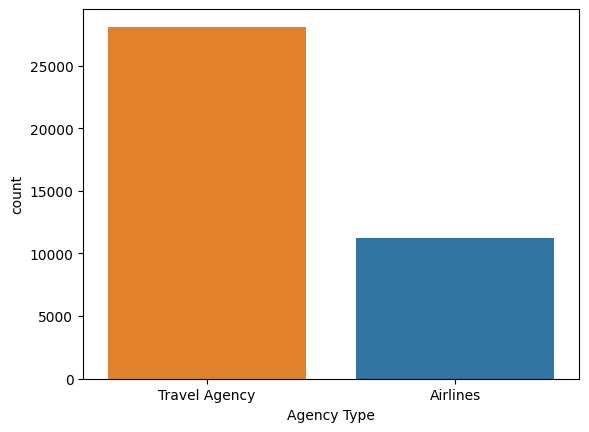

In [22]:
sns.countplot(data=df, x="Agency Type", hue="Agency Type", order=df['Agency Type'].value_counts().iloc[:10].index)


In [23]:
df_Agency = pd.DataFrame({"Agency Type" : df["Agency Type"].value_counts().index,
                          "Jumlah" : df["Agency Type"].value_counts().values,
                          "Persentase" : (df["Agency Type"].value_counts(normalize=True)*100).round(2).values})
df_Agency

,Agency Type,Jumlah,Persentase
0,Travel Agency,28096,71.45
1,Airlines,11228,28.55


Kolom `Agency Type` hanya memiliki 2 unik data maka tidak perlu dilakukan mapping.

`Agency Type` terbanyak berada pada data 'Travel Agency' dengan jumlah 28096 (71.45%)

#### 3. Feature `Distribution Channel`

In [24]:
(pd.crosstab(df['Distribution Channel'], df['Claim'], normalize="all")*100).round(3).sort_values(1,ascending=False)

Claim,0,1
Distribution Channel,,
Online,96.508,1.683
Offline,1.780,0.028


<Axes: xlabel='Distribution Channel', ylabel='count'>

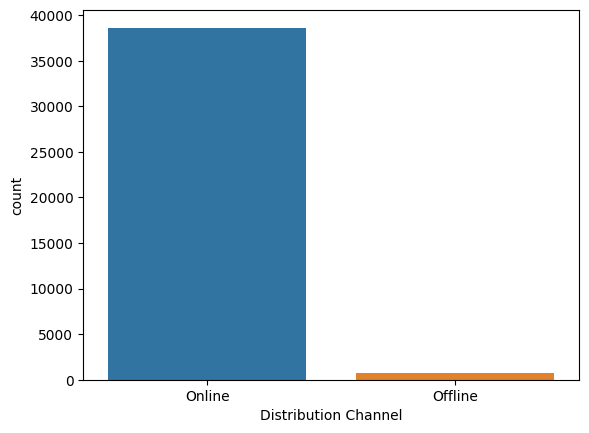

In [25]:
sns.countplot(data=df, x="Distribution Channel", hue="Distribution Channel", order=df['Distribution Channel'].value_counts().index)

In [26]:
df_Distribution = pd.DataFrame({"Distribution Channel" : df["Distribution Channel"].value_counts().index,
                          "Jumlah" : df["Distribution Channel"].value_counts().values,
                          "Persentase" : (df["Distribution Channel"].value_counts(normalize=True)*100).round(2).values})
df_Distribution

,Distribution Channel,Jumlah,Persentase
0,Online,38613,98.19
1,Offline,711,1.81


Kolom `Distribution Channel` hanya memiliki 2 unik data maka tidak perlu dilakukan mapping.

`Distribution Channel` terbanyak berada pada data 'Online' dengan jumlah 386136 (98.19%)

#### 4. Feature `Product Name`

In [27]:
(pd.crosstab(df['Product Name'], df['Claim'], normalize="all")*100).round(3).sort_values(1,ascending=False)

Claim,0,1
Product Name,,
Bronze Plan,6.291,0.407
Silver Plan,3.489,0.275
Annual Silver Plan,1.887,0.272
2 way Comprehensive Plan,20.440,0.242
Rental Vehicle Excess Insurance,14.398,0.163
Cancellation Plan,27.917,0.079
Annual Gold Plan,0.305,0.041
Basic Plan,9.211,0.041
Value Plan,3.903,0.036


`Product Name`: 'Bronze Plan', 'Silver Plan', 'Annual Silver PlanT', '2 way Comprehensive Plan', 'Rental Vehicle Excess Insurance', 'Cancellation Plan' mempengaruhi `Claim` kelas 1 lumayan signifikan dibanding `Product Name` lainnya.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Cancellation Plan'),
  Text(1, 0, '2 way Comprehensive Plan'),
  Text(2, 0, 'Rental Vehicle Excess Insurance'),
  Text(3, 0, 'Basic Plan'),
  Text(4, 0, 'Bronze Plan'),
  Text(5, 0, '1 way Comprehensive Plan'),
  Text(6, 0, 'Value Plan'),
  Text(7, 0, 'Silver Plan'),
  Text(8, 0, 'Annual Silver Plan'),
  Text(9, 0, 'Ticket Protector')])

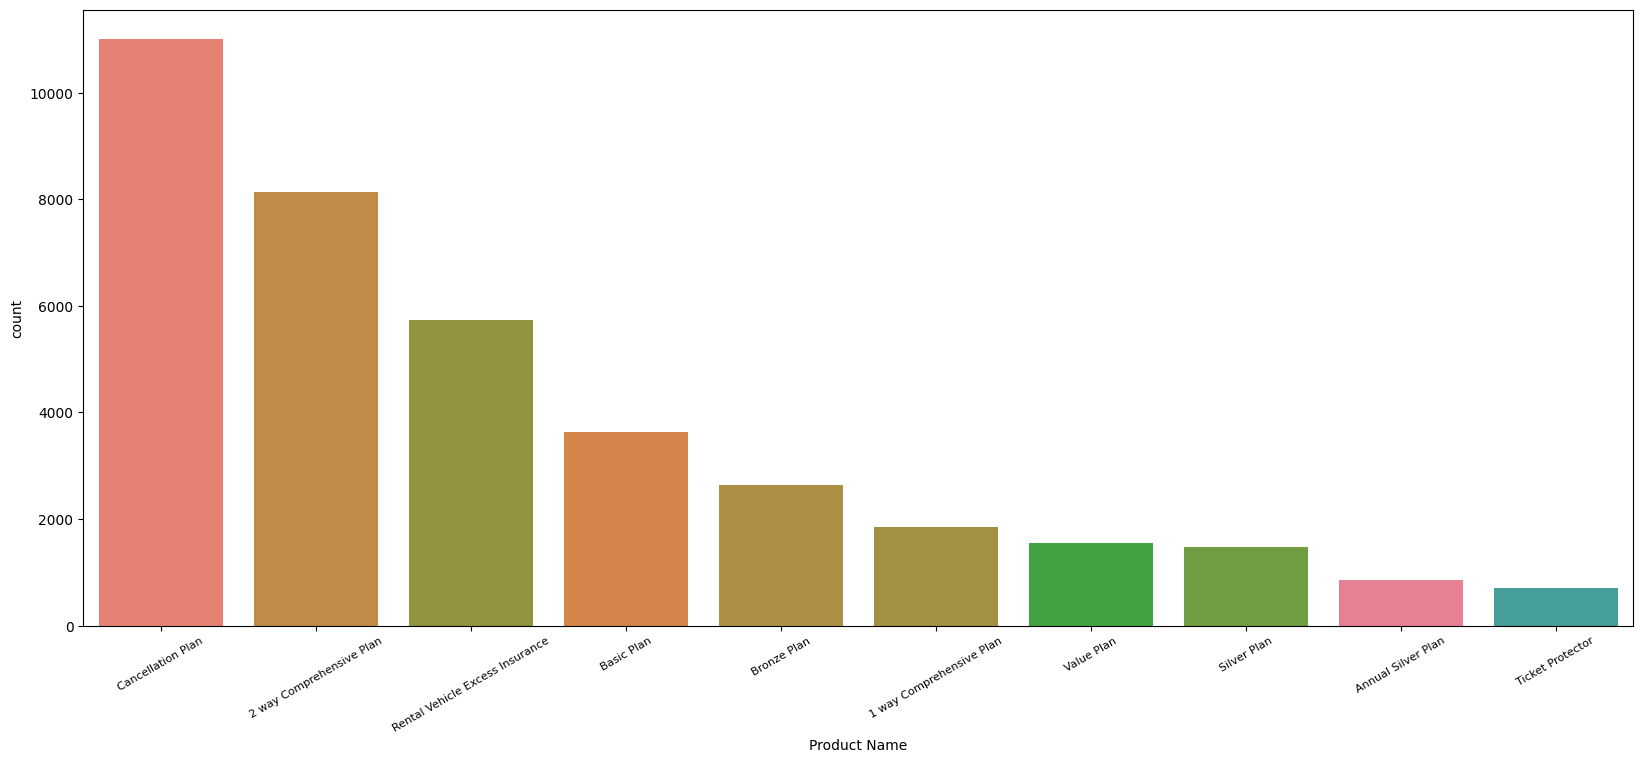

In [28]:
plt.figure(figsize=(20,8))
sns.countplot(data=df, x="Product Name", hue="Product Name", order=df['Product Name'].value_counts().iloc[:10].index)
plt.xticks(rotation=30, fontsize=8)

In [29]:
df_Product = pd.DataFrame({"Product Name" : df["Product Name"].value_counts().index,
                          "Jumlah" : df["Product Name"].value_counts().values,
                          "Persentase" : (df["Product Name"].value_counts(normalize=True)*100).round(2).values})
df_Product

,Product Name,Jumlah,Persentase
0,Cancellation Plan,11009,28.00
1,2 way Comprehensive Plan,8133,20.68
2,Rental Vehicle Excess Insurance,5726,14.56
3,Basic Plan,3638,9.25
4,Bronze Plan,2634,6.70
5,1 way Comprehensive Plan,1848,4.70
6,Value Plan,1549,3.94
7,Silver Plan,1480,3.76
8,Annual Silver Plan,849,2.16
9,Ticket Protector,711,1.81


In [30]:
def mapping_Product(x):
    if x in ['Bronze Plan', 'Silver Plan', 'Annual Silver PlanT', '2 way Comprehensive Plan', 'Rental Vehicle Excess Insurance', 'Cancellation Plan']:
        return x
    else:
        return 'Others'
df['Product Name'] = df['Product Name'].apply(mapping_Product)
df['Product Name'].unique()

array(['Others', 'Cancellation Plan', '2 way Comprehensive Plan',
       'Bronze Plan', 'Rental Vehicle Excess Insurance', 'Silver Plan'],
      dtype=object)

Pada kolom `Product Name` data selain 'Bronze Plan', 'Silver Plan', 'Annual Silver PlanT', '2 way Comprehensive Plan', 'Rental Vehicle Excess Insurance','Cancellation Plan' akan diubah menjadi 'Others'

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Cancellation Plan'),
  Text(1, 0, 'Others'),
  Text(2, 0, '2 way Comprehensive Plan'),
  Text(3, 0, 'Rental Vehicle Excess Insurance'),
  Text(4, 0, 'Bronze Plan'),
  Text(5, 0, 'Silver Plan')])

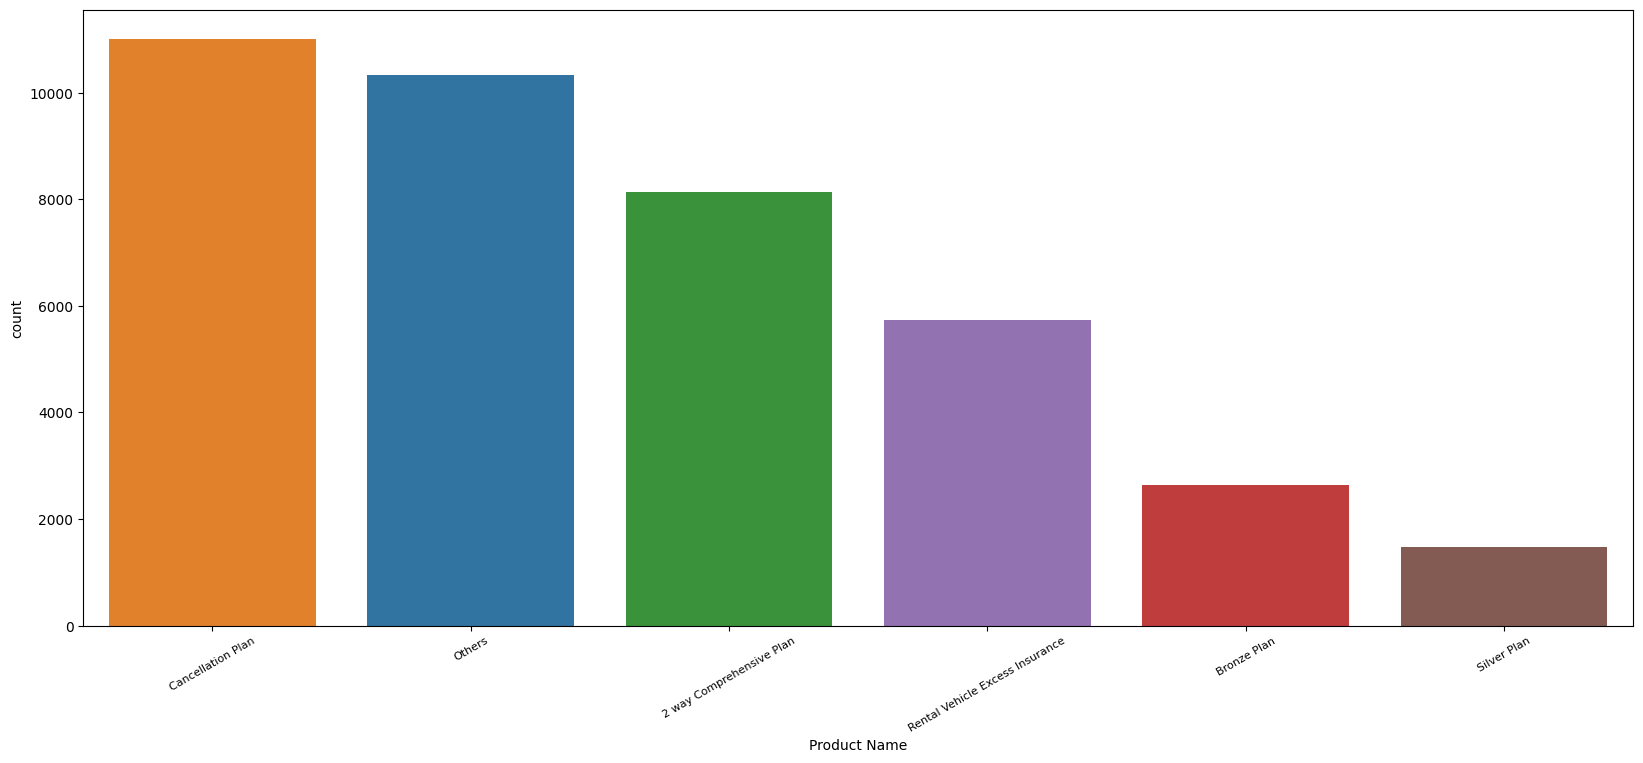

In [31]:
plt.figure(figsize=(20,8))
sns.countplot(data=df, x="Product Name", hue="Product Name", order=df['Product Name'].value_counts().iloc[:10].index)
plt.xticks(rotation=30, fontsize=8)

In [32]:
df_Product = pd.DataFrame({"Product Name" : df["Product Name"].value_counts().index,
                          "Jumlah" : df["Product Name"].value_counts().values,
                          "Persentase" : (df["Product Name"].value_counts(normalize=True)*100).round(2).values})
df_Product

,Product Name,Jumlah,Persentase
0,Cancellation Plan,11009,28.00
1,Others,10342,26.30
2,2 way Comprehensive Plan,8133,20.68
3,Rental Vehicle Excess Insurance,5726,14.56
4,Bronze Plan,2634,6.70
5,Silver Plan,1480,3.76


`Product Name` terbanyak berada pada data 'Cancellation Plan' dengan jumlah 11009 (28.00%)

#### 5. Feature `Destination`

In [33]:
(pd.crosstab(df['Destination'], df['Claim'], normalize="all")*100).round(3).sort_values(1,ascending=False)

Claim,0,1
Destination,,
SINGAPORE,19.563,1.050
CHINA,7.370,0.084
AUSTRALIA,6.162,0.076
UNITED STATES,4.308,0.074
THAILAND,9.244,0.061
...,...,...
GUADELOUPE,0.003,0.000
GHANA,0.008,0.000
GEORGIA,0.028,0.000


`Destination`: 'SINGAPORE', 'CHINA', 'AUSTRALIA', 'UNITED STATES', 'THAILAND' mempengaruhi `Claim` kelas 1 lumayan signifikan dibanding `Destination` lainnya.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'SINGAPORE'),
  Text(1, 0, 'THAILAND'),
  Text(2, 0, 'MALAYSIA'),
  Text(3, 0, 'CHINA'),
  Text(4, 0, 'AUSTRALIA'),
  Text(5, 0, 'INDONESIA'),
  Text(6, 0, 'UNITED STATES'),
  Text(7, 0, 'HONG KONG'),
  Text(8, 0, 'PHILIPPINES'),
  Text(9, 0, 'JAPAN')])

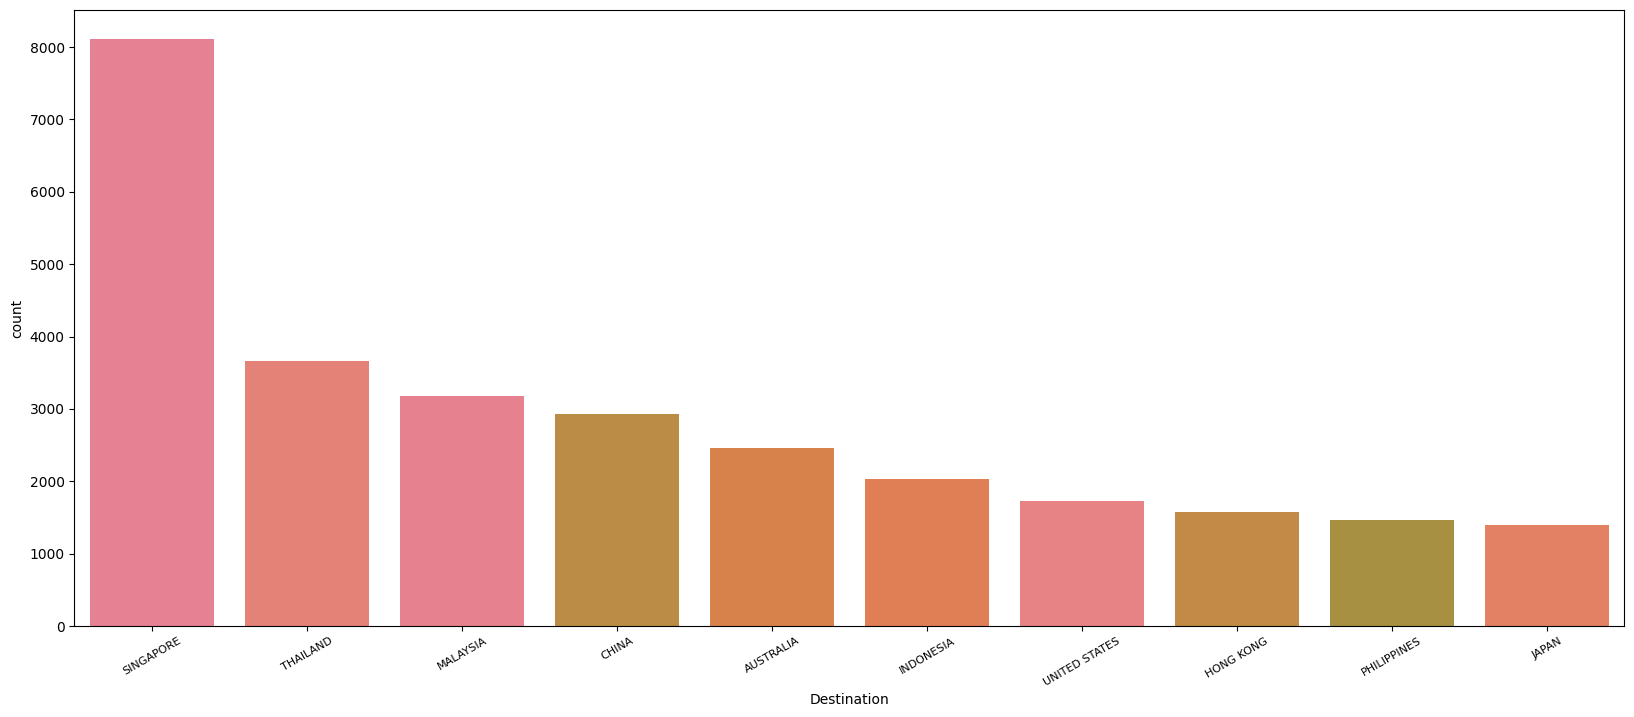

In [34]:
plt.figure(figsize=(20,8))
sns.countplot(data=df, x="Destination", hue="Destination", order=df['Destination'].value_counts().iloc[:10].index)
plt.xticks(rotation=30, fontsize=8)


In [35]:
df_Destination = pd.DataFrame({"Destination" : df["Destination"].value_counts().index,
                          "Jumlah" : df["Destination"].value_counts().values,
                          "Persentase" : (df["Destination"].value_counts(normalize=True)*100).round(2).values})
df_Destination

,Destination,Jumlah,Persentase
0,SINGAPORE,8106,20.61
1,THAILAND,3659,9.30
2,MALAYSIA,3173,8.07
3,CHINA,2931,7.45
4,AUSTRALIA,2453,6.24
...,...,...,...
133,JAMAICA,1,0.00
134,ANGOLA,1,0.00
135,FRENCH POLYNESIA,1,0.00
136,NIGERIA,1,0.00


In [36]:
def mapping_Destination(x):
    if x in ['SINGAPORE', 'CHINA', 'AUSTRALIA', 'UNITED STATES', 'THAILAND']:
        return x
    else:
        return 'Others'
df['Destination'] = df['Destination'].apply(mapping_Destination)
df['Destination'].unique()

array(['SINGAPORE', 'Others', 'UNITED STATES', 'THAILAND', 'AUSTRALIA',
       'CHINA'], dtype=object)

Pada kolom `Destination` data selain 'SINGAPORE', 'CHINA', 'AUSTRALIA', 'UNITED STATES', 'THAILAND' akan diubah menjadi 'Others'

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Others'),
  Text(1, 0, 'SINGAPORE'),
  Text(2, 0, 'THAILAND'),
  Text(3, 0, 'CHINA'),
  Text(4, 0, 'AUSTRALIA'),
  Text(5, 0, 'UNITED STATES')])

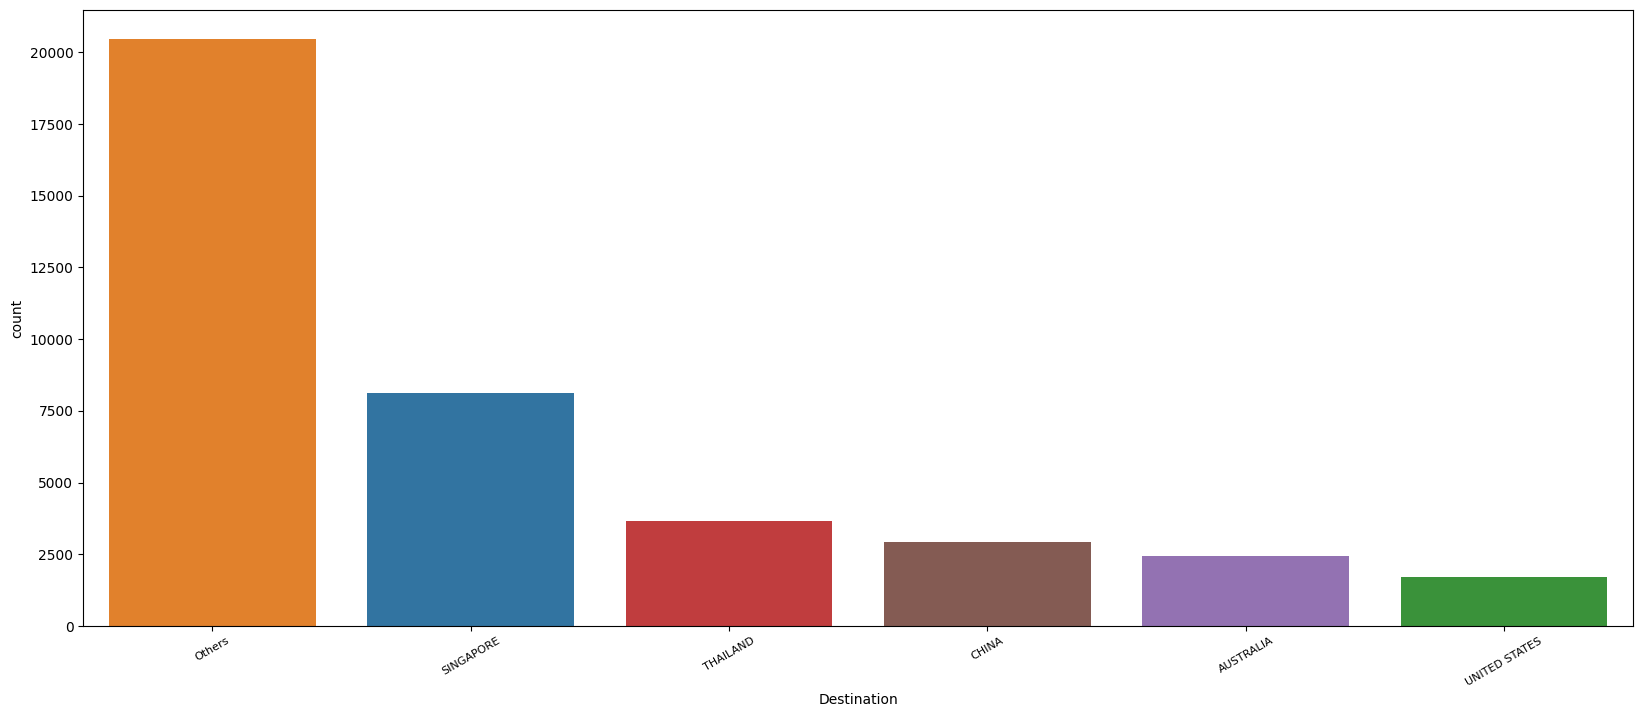

In [37]:
plt.figure(figsize=(20,8))
sns.countplot(data=df, x="Destination", hue="Destination", order=df['Destination'].value_counts().iloc[:10].index)
plt.xticks(rotation=30, fontsize=8)

In [38]:
df_Destination = pd.DataFrame({"Destination" : df["Destination"].value_counts().index,
                          "Jumlah" : df["Destination"].value_counts().values,
                          "Persentase" : (df["Destination"].value_counts(normalize=True)*100).round(2).values})
df_Destination

,Destination,Jumlah,Persentase
0,Others,20452,52.01
1,SINGAPORE,8106,20.61
2,THAILAND,3659,9.30
3,CHINA,2931,7.45
4,AUSTRALIA,2453,6.24
5,UNITED STATES,1723,4.38


`Destination` terbanyak berada pada data 'SINGAPORE' dengan jumlah 8106 (20.61%)

### Distribusi Kolom Numerikal

Kolom Numerikal:

- Duration
- Net Sales
- Commision (in Value)
- Age

Memeriksa distribusi kolom Numerikal untuk mengetahui keberadaan outliers

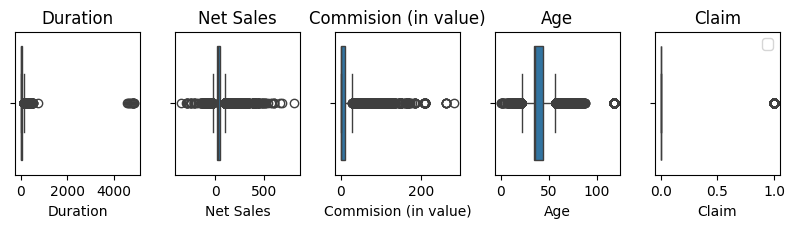

In [39]:
column_numerical = []

for i in df.columns:
    if (df[i].dtype == "float64") | (df[i].dtype == 'int64'):
        column_numerical.append(i)

plt.figure(figsize=(16, 8))  
for i, column in enumerate(column_numerical):
    plt.subplot(4, 10, i + 1)  
    sns.boxplot(data=df, x=column)
    plt.title(column)
plt.legend()
plt.tight_layout()
plt.show()

Outlier tidak dihapus melainkan akan di Scaling pada saat Data Preprocessing

In [40]:
data=[]
for i in df.columns:
    data.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum())/len(df))*100),2),
        df[i].nunique(),
        df[i].drop_duplicates().values
    ])

pd.DataFrame(data, columns=[
    'kolom',
    'tipe',
    'null',
    'persentase null',
    'unique',
    'unique Data'
])

,kolom,tipe,null,persentase null,unique,unique Data
0,Agency,object,0,0.0,5,"[C2B, EPX, Others, CWT, LWC]"
1,Agency Type,object,0,0.0,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.0,2,"[Online, Offline]"
3,Product Name,object,0,0.0,6,"[Others, Cancellation Plan, 2 way Comprehensiv..."
4,Duration,int64,0,0.0,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 37..."
5,Destination,object,0,0.0,6,"[SINGAPORE, Others, UNITED STATES, THAILAND, A..."
6,Net Sales,float64,0,0.0,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 8..."
7,Commision (in value),float64,0,0.0,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88,..."
8,Age,int64,0,0.0,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 5..."
9,Claim,int64,0,0.0,2,"[0, 1]"


- Encoding:
    - OneHot Encoding : 'Agency', 'Agency Type', 'Distribution Channe', 'Product Name', 'Destination'
- Scaling:
    - RobustScaler : 'Duration', 'Net Sales', 'Commision (in value)'
    - Binning Ordinal (Quantile) : 'Age'

## Data Preparation

In [41]:
# Define Target & Feature
y = df['Claim']
X = df.drop(columns = 'Claim')

# Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify = y,
    test_size = 0.2, 
    random_state = 0
)

Pada proses preprocessing pada fitur-fitur yang kita miliki akan dilakukan encoding dan scaling yang dibagi menjadi seperti berikut:
- Encoding
    - kolom `Agency` merupakan kolom kategorikal dengan jumlah unik data 5. (**One Hot Encoder**)
    - kolom `Agency Type` merupakan kolom kategorikal dengan jumlah unik data 2. (**One Hot Encoder**)
    - kolom `Distribution Channel` merupakan kolom kategorikal dengan jumlah unik data 2. (**One Hot Encoder**)
    - kolom `Product Name` merupakan kolom kategorikal dengan jumlah unik data 6. (**One Hot Encoder**)
    - kolom `Destination` merupakan kolom kategorikal dengan jumlah unik data 6. (**One Hot Encoder**)
- Scaling
    - kolom `Duration` merupakan kolom numerikal dengan outlier. (**Robust Scaling**)
    - kolom `Net Sales` merupakan kolom numerikal dengan outlier. (**Robust Scaling**)
    - kolom `Commision (in value)` merupakan kolom numerikal dengan outlier. (**Robust Scaling**)
    - kolom `Age` merupakan kolom numerikal dengan outlier, tetapi berbeda dengan kolom numerikal lainnya, kolom `Age` berpengaruh kepada resiko asuransi maka perlunya pengelompokan ordinal untuk mempertahankan informasi tentang urutan umur. (**Binning Ordinal**)

In [42]:
onehot = OneHotEncoder(drop = 'first')
robust = RobustScaler()
disc_ordinal = KBinsDiscretizer(
    strategy='quantile', 
    n_bins=5,
    encode='ordinal'
)

onehot_var = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']
robust_var = ['Duration', 'Net Sales', 'Commision (in value)']

In [43]:
transformer = ColumnTransformer([
    ('one hot', onehot, onehot_var),
    ('binning',disc_ordinal,['Age']),
    ('robust', robust, robust_var)
], remainder = 'passthrough')

## Modeling & Evaluation

### Cross Validation

Dikarenakan data yang sangat imbalance  ekstrim pada target `Claim` dengan ratio **98:2**, oleh karena itu dibutuhkan model yang mampu menangani masalah class imbalance pada dataset yaitu :

- **EasyEnsembleClassifier** : algoritma ensemble yang dirancang untuk menangani masalah class imbalance pada dataset. Algoritma merupakan metode ensemble bagging yang menggabungkan strategi resampling dengan pembelajaran ensemble.
    - Kelebihan : 
        - EasyEnsembleClassifier memastikan bahwa kelas minoritas mendapatkan perhatian yang memadai selama pelatihan.
        - Cocok untuk aplikasi di mana recall penting, seperti deteksi penipuan, diagnosis medis, atau keamanan.
        - Kombinasi prediksi dari beberapa model meningkatkan stabilitas dan akurasi dibandingkan menggunakan model tunggal.
    - Kekurangan :
        - Melatih beberapa model pada subset yang berbeda bisa lebih memakan waktu dibandingkan metode sederhana.
        - Kurang Cocok untuk Dataset Kecil

- **BalancedBaggingClassifier** : metode ensemble berbasis bagging yang dirancang untuk menangani class imbalance pada dataset. Algoritma ini menggunakan kombinasi antara resampling data (biasanya undersampling kelas mayoritas) dan ensemble learning untuk melatih beberapa model dengan data yang lebih seimbang.
    - Kelebihan : 
        - Mengatasi ketidakseimbangan kelas secara otomatis.
        - Dapat menggunakan model dasar apa pun, bukan hanya Decision Tree. Ini membuat algoritma fleksibel untuk berbagai jenis dataset.
        - Dengan melatih beberapa model pada data yang berbeda, ensemble meningkatkan akurasi dan stabilitas prediksi.
        - Cocok untuk kasus di mana tujuan utama adalah mendeteksi sebanyak mungkin instance dari kelas minoritas, seperti dalam deteksi penipuan atau diagnosis penyakit.
    - Kekurangan :
        - Kebutuhan komputasi.
        - Menggunakan undersampling, beberapa informasi penting dari kelas mayoritas mungkin hilang.
- **RUSBoostClassifier** :  metode ensemble berbasis boosting yang dirancang untuk menangani class imbalance pada dataset dengan metode RUS (Random Under Sampling) dan Adaboost.
    - Kelebihan : 
        - Dengan melakukan undersampling pada setiap iterasi, kelas minoritas mendapatkan perhatian lebih selama pelatihan, mengurangi bias terhadap kelas mayoritas.
        - Memanfaatkan kekuatan boosting.
    - Kekurangan :
        - Karena menggunakan random undersampling, beberapa informasi penting dari kelas mayoritas bisa hilang, terutama pada dataset kecil.
        - Kinerja algoritma tergantung pada jumlah iterasi boosting (n_estimators) dan tingkat undersampling.
- **BalancedRandomForestClassifier** : algoritma ensemble yang merupakan variasi dari Random Forest yang dirancang khusus untuk menangani class imbalance pada dataset. Ini merupakan metode yang menggabungkan random forest dengan teknik undersampling untuk menangani masalah ketidakseimbangan kelas.
    - Kelebihan : 
        - Menangani ketidakseimbangan dengan efektif.
        - Robust terhadap Overfitting.
        - Meningkatkan Recall dan AUC.
        - Memanfaatkan kekuatan boosting.
    - Kekurangan :
        - Kebutuhan komputasi.
        - Menggunakan undersampling, beberapa informasi penting dari kelas mayoritas mungkin hilang.
- **RandomForestClassifier** : algoritma ensemble learning yang menggunakan pendekatan bagging untuk membangun sekumpulan pohon keputusan (decision trees). Setiap pohon dalam Random Forest dilatih menggunakan subset data yang berbeda yang dipilih secara acak (dengan penggantian), dan hasil prediksi akhir diambil melalui metode voting mayoritas.
    - Kelebihan : 
        - Bagging untuk mengurangi variansi.
        - Robust terhadap overfitting pada dataset besar.
    - Kekurangan :
        - Bias terhadap kelas mayoritas.
        - Prediksi kelas minoritas yang tidak akurat.
        - Kinerja menurun pada ketidakseimbangan ekstrim.
- **XGBClassifier** : bekerja dengan cara membangun model secara bertahap, di mana setiap model berikutnya (pohon keputusan) diperbaiki untuk mengurangi kesalahan yang dibuat oleh model sebelumnya. Setiap pohon baru berfokus pada memperbaiki kesalahan yang ada, sehingga model secara keseluruhan dapat memberikan hasil yang lebih akurat.
    - Kelebihan : 
        - Meningkatkan recall untuk kelas minoritas.
        - Flexibilitas pada Loss Function.
        - Kemampuan untuk menggunakan Feature Importance.
    - Kekurangan :
        - Komputasi yang relatif mahal.
        - Overfitting pada data yang sangat tidak seimbang.
- **LGBMClassifier** : algoritma boosting yang dikembangkan oleh Microsoft dan dirancang untuk memberikan performansi tinggi dan kecepatan pelatihan. LightGBM merupakan algoritma yang berbasis gradient boosting karena mengimplementasikan beberapa teknik yang meningkatkan efisiensi dan kinerjanya, seperti Histogram-based Decision Tree Learning dan leaf-wise tree growth.
    - Kelebihan : 
        - Efisiensi pada dataset besar.
        - Kemampuan untuk menghindari overfitting.
        - Kemampuan untuk menggunakan Feature Importance.
    - Kekurangan :
        - Tuning parameter yang kompleks.
        - Overfitting pada data yang sangat tidak seimbang.
- **CatBoostClassifier** : algoritma gradient boosting yang dikembangkan oleh Yandex. CatBoost dirancang untuk memberikan performansi tinggi, kecepatan pelatihan, dan kemudahan dalam menangani data kategori secara langsung tanpa perlu konversi yang rumit.
    - Kelebihan : 
        - Optimasi untuk data kategori.
        - Efisiensi dan kecepatan pelatihan.
        - Tuning yang mudah dan otomatis.
        - Stabilitas model.
        - AUC dan recall lebih baik pada kelas minoritas,
    - Kekurangan :
        - Kinerja menurun pada ketidakseimbangan ekstrim.

In [44]:
model_dict = {'EasyEnsembleClassifier': EasyEnsembleClassifier(random_state=0),
              'BalancedBaggingClassifier': BalancedBaggingClassifier(random_state=0),
              'RUSBoostClassifier':RUSBoostClassifier(random_state=0),
              'BalancedRandomForestClassifier':BalancedRandomForestClassifier(random_state=0),
              "RandomForestClassifier" : RandomForestClassifier(class_weight='balanced',random_state=0),
              "XGBClassifier" : XGBClassifier(scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1]),
              "LGBMClassifier" : lgb.LGBMClassifier(scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1]),
              "CatBoostClassifier" : CatBoostClassifier(random_state=0,auto_class_weights='Balanced')}

### Model Benchmarking : K-Fold

In [45]:
score=[]
rata=[]
std=[]

for model in model_dict:
    skfold=StratifiedKFold(n_splits = 5, shuffle=True, random_state=0)
    estimator=Pipeline([
        ('preprocessing', transformer),
        (model,model_dict[model])])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring="recall")
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())


[LightGBM] [Info] Number of positive: 431, number of negative: 24736
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 25167, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017126 -> initscore=-4.049907
[LightGBM] [Info] Start training from score -4.049907
[LightGBM] [Info] Number of positive: 430, number of negative: 24737
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 25167, number of used features: 20
[LightGBM] [Info] [binar

In [46]:
df_cv = pd.DataFrame({
    'algo': [model for model in model_dict],
    'mean recall': rata,
    'std': std,
    'all': score
})

df_cv.sort_values("mean recall", ascending=False)

,algo,mean recall,std,all
3,BalancedRandomForestClassifier,0.762098,0.006810,"[0.7663551401869159, 0.75, 0.7592592592592593,..."
0,EasyEnsembleClassifier,0.711925,0.027816,"[0.7383177570093458, 0.6759259259259259, 0.75,..."
1,BalancedBaggingClassifier,0.626462,0.017483,"[0.6448598130841121, 0.6018518518518519, 0.611..."
6,LGBMClassifier,0.520578,0.038454,"[0.5700934579439252, 0.4537037037037037, 0.518..."
7,CatBoostClassifier,0.448044,0.026650,"[0.4766355140186916, 0.42592592592592593, 0.40..."
2,RUSBoostClassifier,0.409398,0.319373,"[0.9719626168224299, 0.3611111111111111, 0.5, ..."
5,XGBClassifier,0.364348,0.033768,"[0.40186915887850466, 0.32407407407407407, 0.3..."
4,RandomForestClassifier,0.083679,0.020464,"[0.102803738317757, 0.046296296296296294, 0.10..."


Terlihat bahwa model **BalancedRandomForestClassifier** adalah yang terbaik untuk recallnya dari setiap model yang menggunakan default hyperparameter

### Model Benchmarking : Test Data

In [47]:
score=[]

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocessing', transformer),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for model in model_dict:
    estimator=Pipeline([
        ('preprocessing', transformer),
        ('model',model_dict[model])])
    
    estimator.fit(X_train,y_train)

    y_pred = estimator.predict(X_test)
    score.append(recall_score(y_test,y_pred))



[LightGBM] [Info] Number of positive: 538, number of negative: 30921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 31459, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017102 -> initscore=-4.051332
[LightGBM] [Info] Start training from score -4.051332
Learning rate set to 0.044923
0:	learn: 0.6770662	total: 11.3ms	remaining: 11.3s
1:	learn: 0.6620588	total: 25.7ms	remaining: 12.8s
2:	learn: 0.6475953	total: 39.4ms	remaining: 13.1s
3:	learn: 0.6354097	total: 54.3ms	remaining: 13.5s
4:	learn: 0.6238332	total: 68.5ms	remaining: 13.6s
5:	learn: 0.6131079	total: 83.2ms	remaining: 13.8s
6:	learn: 0.6037725	total: 94.7ms	remaining: 13.4s
7:	learn: 0.5966013	total: 108ms	remaining: 13.4s
8:	learn

In [48]:
df_cv = pd.DataFrame({
    'model': [model for model in model_dict],
    'recall score': score
})

df_cv.sort_values("recall score", ascending=False)

,model,recall score
3,BalancedRandomForestClassifier,0.725926
0,EasyEnsembleClassifier,0.688889
2,RUSBoostClassifier,0.681481
1,BalancedBaggingClassifier,0.622222
6,LGBMClassifier,0.511111
7,CatBoostClassifier,0.488889
5,XGBClassifier,0.429630
4,RandomForestClassifier,0.088889


Terlihat kembali lagi model **BalancedRandomForestClassifier** adalah yang terbaik performanya pada test data.

Maka untuk seterusnya kita akan menggunakan **BalancedRandomForestClassifier** sebagai model untuk dataset yang kita miliki.

Sebelum melanjutkan ke tahap selanjutnya yait Hyperparameter Tuning, saya akan sedikit menjelaskan langkah kerja dari **BalancedRandomForestClassifier**.

<img src='BRFC.PNG'>

**BalancedRandomForestClassifier** adalah varian dari Random Forest yang dikembangkan untuk menangani masalah ketidakseimbangan kelas dalam klasifikasi. BalancedRandomForestClassifier mengatasi masalah ini dengan melakukan undersampling pada kelas mayoritas secara otomatis saat membangun setiap pohon keputusan di dalam hutan, agar kelas minoritas lebih diperhatikan.

Langkah-langkah Kerja BalancedRandomForestClassifier : 
- Pembagian Data (Bootstrapping):

    - Seperti Random Forest biasa, BalancedRandomForestClassifier memulai dengan bootstrapping atau sampling acak dengan pengembalian (sampling dengan pengulangan) untuk membuat beberapa subset data pelatihan yang berbeda. Ini akan menjadi basis untuk masing-masing pohon dalam hutan.

- Undersampling Kelas Mayoritas:

    - Pada setiap langkah bootstrapping, sebelum membangun pohon keputusan, BalancedRandomForestClassifier melakukan undersampling pada kelas mayoritas. Ini berarti bahwa sebagian data kelas mayoritas secara acak dihapus sehingga jumlahnya menjadi lebih seimbang dengan kelas minoritas.
    - Hal ini dilakukan agar pohon-pohon dalam hutan memiliki distribusi kelas yang lebih seimbang dan dapat belajar lebih baik untuk memprediksi kelas minoritas, yang sering kali lebih sulit diprediksi pada data yang tidak seimbang.

- Pembangunan Pohon Keputusan:

    - Setelah pembagian data dan undersampling, pohon keputusan dibangun seperti biasa menggunakan teknik pembelajaran pohon keputusan. Algoritma ini menggunakan fitur acak dan proses pembagian yang bertujuan untuk meminimalkan impurity (ketidakmurnian) pada setiap simpul pohon, dengan menggunakan kriteria seperti Gini impurity atau entropy.
    - Pembagian data dalam pohon keputusan dilakukan secara standar, namun pada setiap pohon, datasetnya sudah melalui proses undersampling pada kelas mayoritas.

- Voting dan Agregasi:

    - Setelah pohon-pohon dibangun, setiap pohon dalam hutan membuat prediksi untuk data uji. Prediksi dari seluruh pohon digabungkan dengan menggunakan voting mayoritas (untuk klasifikasi), yang menghasilkan keputusan akhir.
    - Dalam kasus klasifikasi, BalancedRandomForestClassifier menerapkan voting pada semua pohon untuk memutuskan kelas mana yang akan dipilih. Setiap pohon memberikan kontribusi yang setara, meskipun pohon tersebut dibangun dengan data yang lebih seimbang.

- Menangani Ketidakseimbangan Data Secara Efektif:

    - Karena setiap pohon dilatih dengan distribusi kelas yang lebih seimbang, model ini lebih fokus pada kelas minoritas dan lebih mampu menangani false negatives yang sering terjadi pada kelas minoritas dalam dataset yang tidak seimbang.

## Hyperparameter Tuning

Refrensi : 
1. https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html
2. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
3. https://medium.com/cloudvillains/random-forest-with-grid-search-b739fb0da311

In [49]:
model = BalancedRandomForestClassifier(random_state=0)

hyperparam = {
    "model__n_estimators": np.arange(100, 201, 25),  
    "model__criterion": ['gini', 'entropy'], 
    "model__max_features": ['sqrt', 'log2', None, 1.0, 1/3],  
    "model__min_samples_leaf": np.arange(1, 16),
    "model__min_samples_split": np.arange(2, 16),
    "model__max_depth": np.arange(5, 16)
}

default hyperparameter **BalancedRandomForestClassifier** => `n_estimators` = 100, `criterion` = gini, `max_features` = sqrt, `min_samples_leaf` = 1, `min_samples_split` = 2, `max_depth` = None

In [50]:
estimator=Pipeline([
        ('preprocessing', transformer),
        ('model',model)])

randomsearch = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=hyperparam,
    n_iter=500,
    cv=StratifiedKFold(n_splits = 5, shuffle=True, random_state=0),
    scoring='recall',
    n_jobs=-1,
    random_state=0
)

randomsearch

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one '
                                                                               'hot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Agency',
                                                                                'Agency '
                                                                                'Type',
                                                                                'Distribution '
                                                                                'Channel',
                                                                                'Product '
                                                                                'Name',
                                                                                'Destination']),
                                                                              ('binning',
                                                                               KBinsDiscretizer(encode='ordinal'),
                                                                               ['Age'...
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'model__max_features': ['sqrt', 'log2',
                                                                None, 1.0,
                                                                0.3333333333333333],
                                        'model__min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'model__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'model__n_estimators': array([100, 125, 150, 175, 200])},
                   random_state=0, scoring='recall')

In [51]:
randomsearch.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one '
                                                                               'hot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Agency',
                                                                                'Agency '
                                                                                'Type',
                                                                                'Distribution '
                                                                                'Channel',
                                                                                'Product '
                                                                                'Name',
                                                                                'Destination']),
                                                                              ('binning',
                                                                               KBinsDiscretizer(encode='ordinal'),
                                                                               ['Age'...
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'model__max_features': ['sqrt', 'log2',
                                                                None, 1.0,
                                                                0.3333333333333333],
                                        'model__min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'model__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'model__n_estimators': array([100, 125, 150, 175, 200])},
                   random_state=0, scoring='recall')

In [52]:
randomsearch.best_score_

0.7584285219799238

In [53]:
randomsearch.best_params_

{'model__n_estimators': 200,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 3,
 'model__max_features': None,
 'model__max_depth': 13,
 'model__criterion': 'gini'}

default hyperparameter **BalancedRandomForestClassifier** => `n_estimators` = 175, `criterion` = entropy, `max_features` = log2, `min_samples_leaf` = 1, `min_samples_split` = 5, `max_depth` = 14

In [54]:
model = BalancedRandomForestClassifier(random_state=0)
estimator=Pipeline([
        ('preprocessing', transformer),
        ('model',model)])
estimator.fit(X_train, y_train)
y_pred_before = estimator.predict(X_test)
display(recall_score(y_test,y_pred_before))

0.725925925925926

In [55]:
best_model = randomsearch.best_estimator_
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
display(recall_score(y_test,y_pred_best))

0.7407407407407407

In [56]:
print('Recall Score Default Balanced Random Forest Classifier : ', recall_score(y_test,y_pred_before))
print('Recall Score Tuned Balanced Random Forest Classifier : ', recall_score(y_test,y_pred_best))

Recall Score Default Balanced Random Forest Classifier :  0.725925925925926
Recall Score Tuned Balanced Random Forest Classifier :  0.7407407407407407


Terlihat bahwa model **Balanced Random Forest Classifier** setelah kita tuning hyperparameternya memiliki nilai Recall yang lebih baik walaupun hanya naik sedikit.

In [57]:
report_default = classification_report(y_test, y_pred_before)
report_tuned = classification_report(y_test, y_pred_best)

In [58]:
print('Classification Report Default : \n', report_default)
print('Classification Report Tuned : \n', report_tuned)

Classification Report Default : 
               precision    recall  f1-score   support

           0       0.99      0.74      0.85      7730
           1       0.05      0.73      0.09       135

    accuracy                           0.74      7865
   macro avg       0.52      0.73      0.47      7865
weighted avg       0.98      0.74      0.84      7865

Classification Report Tuned : 
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      7730
           1       0.05      0.74      0.10       135

    accuracy                           0.77      7865
   macro avg       0.52      0.75      0.48      7865
weighted avg       0.98      0.77      0.85      7865



Dilihat dari Classification report model **Balanced Random Forest Classifier** setelah di tuning berhasil mengoptimalkan Recall score. Oleh karena itu **Balanced Random Forest Classifier** setelah di tuning akan digunakan.

## Confusion Metrics

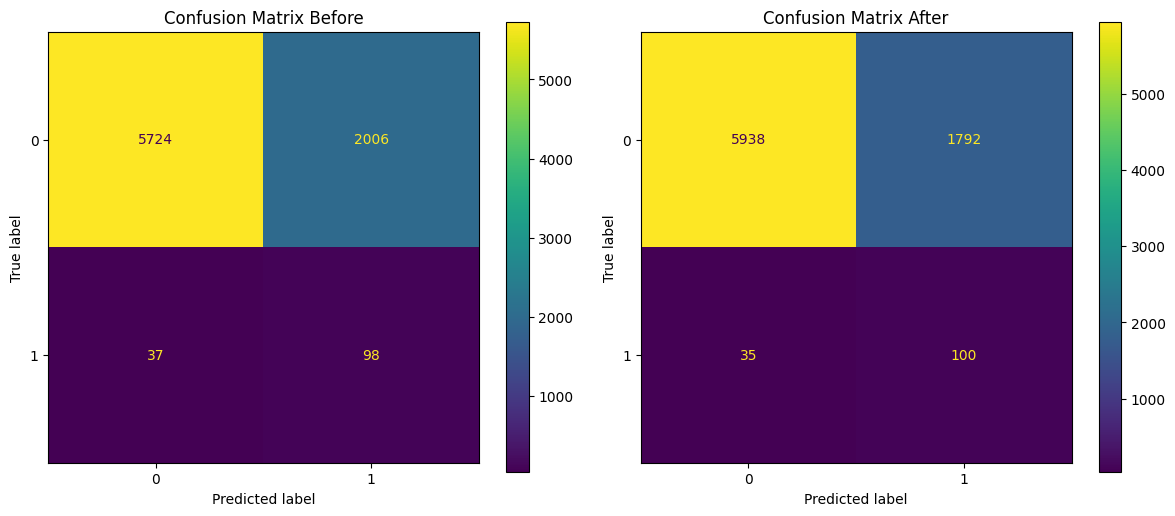

In [59]:
# confusion matrix before
cm_before = confusion_matrix(y_test, y_pred_before)

# confusion matrix after
cm_after = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1,2, figsize=(12,5))

disp_before = ConfusionMatrixDisplay(cm_before)
disp_after = ConfusionMatrixDisplay(cm_after)

axes[0].set_title('Confusion Matrix Before')
axes[1].set_title('Confusion Matrix After')
disp_before.plot(ax=axes[0])
disp_after.plot(ax=axes[1])

plt.tight_layout()
plt.show()

Dari visualisasi diatas membuktikan bahwa model **Balanced Random Forest Classifier** setelah dituning berhasil menurunkan :
- **FN** : 37 -> 33 (-10.8%)
- **FP** : 2006 -> 1780 (-11.2%)

## Feature Importances

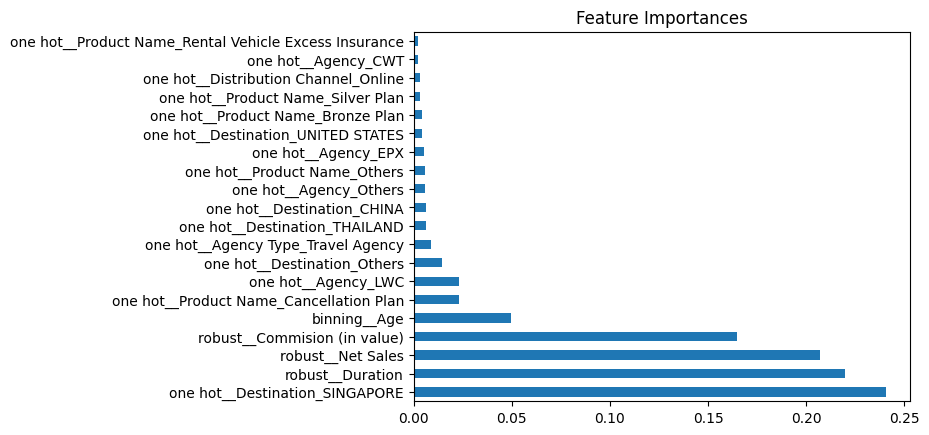

In [60]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Terlihat bahwa ternyata untuk model **Balanced Random Forest Classifier** setelah dituning, fitur/kolom `robust__Duration`, `robust__Net Sale` dan `robust__Commision (in value)` merupakan fitur yang memiliki kontribusi besar terhadap model dan ikuti oleh model-model lainnya.

### Shapley Value of Explanations (SHAP)

In [72]:
best_pipeline = randomsearch.best_estimator_
best_model2 = best_pipeline.named_steps['model']
transformers = best_pipeline[:-1]
X_train_transformed = transformers.transform(X_train)

In [75]:
explainer = shap.TreeExplainer(best_model2)

# Compute SHAP values
shap_values = explainer(X_train_transformed)

# Visualize SHAP summary plot
shap.force_plot(explainer.expected_value, shap_values[0], X_train_transformed[0])

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

## Summary

### Kesimpulan

In [63]:
df_before = pd.read_csv('data_travel_insurance.csv')
df_before

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


In [64]:
data=[]
for i in df_before.columns:
    data.append([
        i,
        df_before[i].dtypes,
        df_before[i].isna().sum(),
        round((((df_before[i].isna().sum())/len(df_before))*100),2),
        df_before[i].nunique(),
        df_before[i].drop_duplicates().values
    ])

pd.DataFrame(data, columns=[
    'kolom',
    'tipe',
    'null',
    'persentase null',
    'unique',
    'unique Data'
])

,kolom,tipe,null,persentase null,unique,unique Data
0,Agency,object,0,0.00,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, ..."
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Annual Silver Plan, Cancellation Plan, Basic ..."
4,Gender,object,31647,71.39,2,"[F, nan, M]"
5,Duration,int64,0,0.00,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 37..."
6,Destination,object,0,0.00,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KO..."
7,Net Sales,float64,0,0.00,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 8..."
8,Commision (in value),float64,0,0.00,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88,..."
9,Age,int64,0,0.00,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 5..."


In [65]:
data=[]
for i in df.columns:
    data.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum())/len(df))*100),2),
        df[i].nunique(),
        df[i].drop_duplicates().values
    ])

pd.DataFrame(data, columns=[
    'kolom',
    'tipe',
    'null',
    'persentase null',
    'unique',
    'unique Data'
])

,kolom,tipe,null,persentase null,unique,unique Data
0,Agency,object,0,0.0,5,"[C2B, EPX, Others, CWT, LWC]"
1,Agency Type,object,0,0.0,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.0,2,"[Online, Offline]"
3,Product Name,object,0,0.0,6,"[Others, Cancellation Plan, 2 way Comprehensiv..."
4,Duration,int64,0,0.0,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 37..."
5,Destination,object,0,0.0,6,"[SINGAPORE, Others, UNITED STATES, THAILAND, A..."
6,Net Sales,float64,0,0.0,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 8..."
7,Commision (in value),float64,0,0.0,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88,..."
8,Age,int64,0,0.0,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 5..."
9,Claim,int64,0,0.0,2,"[0, 1]"
